# Pre-Processing & Modeling

### Pre-Processing

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
# Read the cleaned data
df = pd.read_csv('../datasets/cleaned_posts.csv')

In [3]:
# Convert label
convert_label = {'wallstreetbets': 1, 'SatoshiStreetBets': 0}

# Create a new column with the labeled titles
df['label'] = df['subreddit'].map(convert_label)

# Check code execution
df.head(1)

,subreddit,title,post_char_length,post_word_count,sentiment_compound,sentiment_negative,sentiment_neutral,sentiment_positive,label
0,wallstreetbets,You all should try to SPAC Jeremy Fragrance's ...,53,9,0.0,0.0,1.0,0.0,1


In [4]:
# Check missing values
df.isnull().sum().sum()

0

In [5]:
# All stop words (English stop words + most common words shared between WSB and SSB)
my_stopwords = list(TfidfVectorizer(stop_words='english').get_stop_words()) + ['2021', 'amp', 'best', 'big', 'bought', 'buy', 'buying', 'day', 'don', 'future', 'going', 'good', 'got', 'guys', 'help', 'hold', 'just', 'know', 'let', 'like', 'long', 'make', 'market', 'monday', 'money', 'moon', 'need', 'new', 'people', 'post', 'price', 'right', 'short', 'think', 'time', 'today', 'trading', 'use', 'way', 'week', 'yolo']

### Modeling

#### The Null Model

In [6]:
# Define X and y
X = df['title']
y = df['label']

In [7]:
# Find the majority class
y.value_counts(normalize=True)

0    0.502748
1    0.497252
Name: label, dtype: float64

**Interpretation:** 50.28% of the posts are from r/SatoshiStreetBets, and 49.71% of the posts are from r/wallstreetbets. The baseline accuracy for the null model is 50.28% because r/SatoshiStreetBets is the majority class. My goal will be to construct a classification model that can predict the correct subreddit from which a post comes with an accuracy above 50.28%.

#### Model 1: Logistic Regression

In [8]:
# Define X and y
X = df['title']
y = df['label']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
# Set up transformer and estimator via pipeline
pipe_lr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

In [10]:
# Set up parameters for pipeline
pipe_lr_params = {
    'tvec__stop_words': ['english', my_stopwords],
    'tvec__min_df': [2],
    'logreg__C': [1.0]
}

In [11]:
# Instantiate GridSearchCV
gs_lr = GridSearchCV(estimator=pipe_lr,
                      param_grid=pipe_lr_params,
                      cv=5,
                      verbose=1)

In [12]:
# Fit GridSearchCV
gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [1.0], 'tvec__min_df': [2],
                         'tvec__stop_words': ['english',
                                              ['call', 'latter', 'else', 'up',
                                               'by', 'keep', 'besides',
                                               'between', 'a', 'here', 'five',
                                               'yours', 'nor', 'beyond',
                                               'alone', 'sixty', 'three',
                                               'becoming', 'inc', 'via', 'ours',
                                               'everything', 'during', 'with',
                                               'noone', 'whether', 'down',
                                               'any', 'someone', 'cant', ...]]},
             verbose=1

In [13]:
# Accuracy score for logistic regression
gs_lr.score(X_train, y_train), gs_lr.score(X_test, y_test)

(0.9214659685863874, 0.8169456066945606)

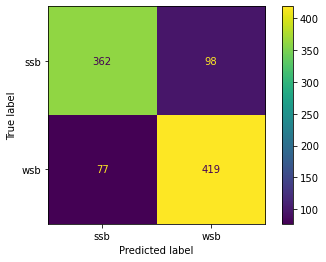

In [14]:
# Predicted y test values
lr_preds = gs_lr.predict(X_test)

# Plot a confusion matrix
plot_confusion_matrix(gs_lr, X_test, y_test, 
                      values_format='d', display_labels=['ssb','wsb']);

In [15]:
# Predicting risk tolerance (i.e. crypto or stock) based on unique words
# Example 1
gs_lr.predict(['gme mooned again today! I want to buy more shares but robinhood just froze'])

array([1])

In [16]:
# Example 2
gs_lr.predict(['bitcoin keeps mooning! do you think elon will pump dogecoin or should I keep buying ada?'])

array([0])

In [17]:
# Example 3
gs_lr.predict(['do your own dd but I am waiting for the next short squeeze'])

array([1])

**Interpretation:** Model 1 is a classification model that utilizes the tf-idf vectorizer and logistic regression within a pipeline to predict the correct subreddit of a post. The countvectorizer was also considered for pre-processing the text data into a structured, numeric X dataframe, but the tf-idf vectorizer actually resulted in a slightly higher test score with less overfitting. I added the 41 most common terms shared between r/wallstreetbets and r/SatoshiStreetBets to improve the accuracy of the model. Given an accuracy score of 81.69% on the test data, this model easily surpasses the baseline and ideal accuracies outlined in the problem statement. A shortcoming of this model is that it is overfit as evidenced by the difference in training and testing accuracy scores. Overall, this is a fairly robust model for predicting the correct subreddit of a post.

In [18]:
# Additional analysis for Model 1

# Define X and y
X = df['title']
y = df['label']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Instantiate and fit the transformer
tvec = TfidfVectorizer(stop_words=my_stopwords, min_df=2)
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

# Instantiate and fit logistic regression
logreg = LogisticRegression()
logreg.fit(X_train_tvec, y_train)

# Create a dataframe showing the feature name and tf-idf weight of the word
my_dict = dict(zip(tvec.get_feature_names(), tvec.idf_))
features_df = pd.DataFrame(data=my_dict.items(), columns=['feature_name','tfidf_weight'])

# View the 10 highest weighted feature names
features_df.sort_values(by=['tfidf_weight'], ascending=False).head(10)

,feature_name,tfidf_weight
627,filecoin,7.86206
1475,squozed,7.86206
1483,stand,7.86206
1481,staked,7.86206
740,harmony,7.86206
1480,stake,7.86206
743,haters,7.86206
744,havent,7.86206
1479,staff,7.86206
746,hbar,7.86206


**Interpretation:** The TF-IDF vectorizer assigns the highest weight as 7.86206. Thus, the words with a weight of approximately 7.86206 can be considered to be the most predictive for this model.

#### Model 2: Random Forest

In [19]:
# Define X and y
X = df['title']
y = df['label']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
# Set up transformer and estimator via pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rfc', RandomForestClassifier())
])

In [21]:
# Set up parameters for pipeline
pipe_params = {
    'tvec__stop_words': ['english', my_stopwords],
    'tvec__min_df': [2],
    'rfc__n_estimators': [100,150,200],
    'rfc__max_depth': [None,1,2,3,4,5]
}

In [22]:
# Instantiate GridSearchCV
gs_cv = GridSearchCV(estimator=pipe,
                      param_grid=pipe_params,
                      cv=5,
                      verbose=1)

In [23]:
# Fit GridSearchCV
gs_cv.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__max_depth': [None, 1, 2, 3, 4, 5],
                         'rfc__n_estimators': [100, 150, 200],
                         'tvec__min_df': [2],
                         'tvec__stop_words': ['english',
                                              ['call', 'latter', 'else', 'up',
                                               'by', 'keep', 'besides',
                                               'between', 'a', 'here', 'five',
                                               'yours', 'nor', 'beyond',
                                               'alone', 'sixty', 'three',
                                               'becoming', 'inc', 'via', 'ours',
                                               'everything', 'during', 'with',
                                               'noone', 'whether', '

In [24]:
# Accuracy score for random forest
gs_cv.score(X_train, y_train), gs_cv.score(X_test, y_test)

(0.9553228621291449, 0.805439330543933)

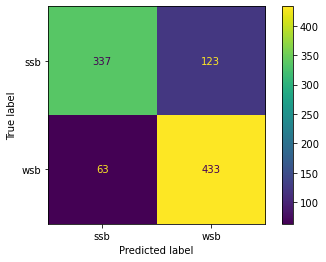

In [25]:
# Predicted y test values
rfc_preds = gs_cv.predict(X_test)

# Plot a confusion matrix
plot_confusion_matrix(gs_cv, X_test, y_test, 
                      values_format='d', display_labels=['ssb','wsb']);

**Interpretation:** Model 2 is a classification model that utilizes the tf-idf vectorizer to pre-process text data, a pipeline to enable gridsearch to iterate over various hyperparameters, and the random forest model to predict the correct subreddit. While the model's accuracy score of 80.54% for the test data exceeds the baseline accuracy, this random forest model does a poorer job at prediction than Model 1. Not only is the accuracy score for testing data lower, but the variance is higher between the training and testing data for Model 2. The random forest model is quite overfit and does not generalize well to new data. Since Model 2 is weaker than Model 1 as a predictive classification model, I will not consider Model 2 for my production model.

#### Model 3: Multinomial Naive Bayes

In [26]:
# Define X and y
X = df['title']
y = df['label']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Set up transformer and estimator via pipeline
pipe_mnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

# Set up parameters for pipeline
pipe_mnb_params = {
    'tvec__max_features': [500,1000,1500,2000],
    'tvec__stop_words': [None, 'english', my_stopwords],
    'tvec__ngram_range': [(1,1),(1,2)]
}

# Instantiate GridSearchCV
gs_mnb = GridSearchCV(pipe_mnb,
                      param_grid=pipe_mnb_params,
                      cv=5,
                     verbose=1)

# Fit GridSearchCV
gs_mnb.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    9.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tvec__max_features': [500, 1000, 1500, 2000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english',
                                              ['call', 'latter', 'else', 'up',
                                               'by', 'keep', 'besides',
                                               'between', 'a', 'here', 'five',
                                               'yours', 'nor', 'beyond',
                                               'alone', 'sixty', 'three',
                                               'becoming', 'inc', 'via', 'ours',
                                               'everything', 'during', 'with',
                                               'noone', 'whether', 'down',
                                   

In [27]:
# Accuracy score for multinomial naive bayes
gs_mnb.score(X_train, y_train), gs_mnb.score(X_test, y_test)

(0.9022687609075044, 0.803347280334728)

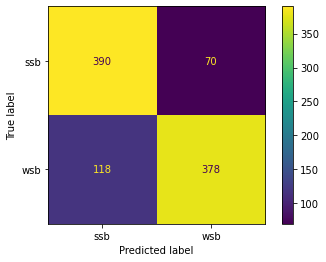

In [28]:
# Predicted y test values
mnb_preds = gs_mnb.predict(X_test)

# Plot a confusion matrix
plot_confusion_matrix(gs_mnb, X_test, y_test, 
                      values_format='d', display_labels=['ssb','wsb']);

**Interpretation:** Model 3 is a classification model that uses the tf-idf vectorizer to process text data, a gridsearch to test the optimal combination of hyperparameters, and the multinomial naive bayes model to predict the correct subreddit of a post. While the model is overfit, it is not as overfit as Model 2. Despite beating the baseline accuracy, Model 3 possesses the lowest testing accuracy score of the three models at 80.33%. As a result, I will not consider Model 3 for the production model.

#### Model 4: Support Vector Classifier

In [29]:
# Define X and y
X = df['title']
y = df['label']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Set up transformer and estimator via pipeline
pipe_svc = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
     ])

# Set up parameters for pipeline
pipe_svc_params = {
    'tvec__stop_words': ['english',my_stopwords],
    'tvec__min_df': [2],
    'svc__C': [0.1,1.0,10.0],
    'svc__kernel': ['linear','rbf','poly','sigmoid']
}

# Instantiate GridSearchCV    
gs_svc = GridSearchCV(pipe_svc,
                      param_grid=pipe_svc_params,
                      cv=5,
                     verbose=1)

# Fit GridSearchCV
gs_svc.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   40.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1.0, 10.0],
                         'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                         'tvec__min_df': [2],
                         'tvec__stop_words': ['english',
                                              ['call', 'latter', 'else', 'up',
                                               'by', 'keep', 'besides',
                                               'between', 'a', 'here', 'five',
                                               'yours', 'nor', 'beyond',
                                               'alone', 'sixty', 'three',
                                               'becoming', 'inc', 'via', 'ours',
                                               'everything', 'during', 'with',
                                               'noone', 'whether', 'down',
          

In [30]:
# Accuracy score for SVC
gs_svc.score(X_train,y_train), gs_svc.score(X_test,y_test)

(0.9458987783595113, 0.8127615062761506)

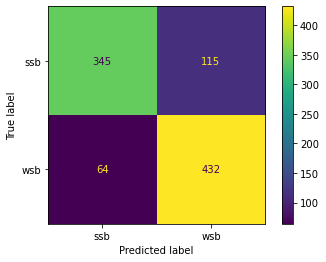

In [31]:
# Predicted y test values
preds_svc = gs_svc.predict(X_test)

# Plot a confusion matrix
plot_confusion_matrix(gs_svc,X_test,y_test,
                      values_format='d',display_labels=['ssb','wsb']);

**Interpretation:** Model 4 is a classification model that utilizes the tf-idf vectorizer to pre-process text data, a gridsearch to determine the optimal mix of hyperparameters, and the support vector classifier model to predict the correct subreddit of a post. The model has high variance and has a decent test accuracy score of 81.27%. Since the predictive capability of Model 4 does not exceed that of Model 1, I will not consider Model 4 for the production model.

### Production Model
The logistic regression model (i.e. Model 1) is my choice for the production model. Since the model has the highest accuracy score for the test data and is one of the less overfit models, I am confident that the model will perform the best at predicting if a post came from r/wallstreetbets or r/SatoshiStreetBets.

### Executive Summary
The goals of this project were two-fold: (1) the first was to process natural language scraped from Pushshift's web API in order to construct a classification model that could predict which of two subreddits a post came from with at least an 80% accuracy score and (2) the second was to determine an investment type (i.e. stock or crypto) that may be more suitable to the individual retail investor based on the keywords with which the individual identifies. Through the iterative process of model tuning, I was able to build a logistic regression model with the desirable accuracy and found the words with the most predictive power for classification. In addition, I performed sentiment analysis to understand the range of positive and negative emotions that are tied to the words used in each subreddit. Based on my findings, it appears that there are words unique to members of r/wallstreetbets and r/SatoshiStreetBets that may inform the individual to side with a particular investment type (i.e. stock or crypto).